# Retrieval-система по статьям с arXiv

Цели:
* разработать retrieval-систему, выполняющую поиск статей по содержинию аннотаций;
* оценить её качество на тестовых запросах и убедиться, что она достигает значения метрики $MRR@5 ≥ 0.91$;
* выполнить профилирование частей модели;
* исследовать возможности оптимизации точности и скорости поиска.

---

## EDA

Цель — загрузить метаданные статей arXiv и датасет с тестовыми запросами, исследовать их структуру и особенности.

Пропишем в коде путь к архиву, который был предварительно скачан по [ссылке](https://disk.yandex.ru/d/_hlESjxRVivrdg) и
распакован.

In [1]:
from pathlib import Path

DATA_DIR = Path('nlp_s3_data/nlp_s3_project')

Загрузим метеданные статей arXiv в таблицу.

In [2]:
import pandas as pd

paper_df = pd.read_json(DATA_DIR / 'arxiv-metadata-s.json').set_index('id')
paper_df

,submitter,authors,title,comments,journal-ref,doi,report-no,categories,license,abstract,versions,update_date,authors_parsed
id,,,,,,,,,,,,,
0704.0038,Maxim A. Yurkin,"Maxim A. Yurkin, Alfons G. Hoekstra",The discrete dipole approximation: an overview...,"36 pages, 1 figure; added several corrections ...","J.Quant.Spectrosc.Radiat.Transf. 106, 558-589 ...",10.1016/j.jqsrt.2007.01.034 10.1016/j.jqsrt.20...,None,physics.optics physics.comp-ph,http://creativecommons.org/licenses/by-nc-nd/4.0/,We present a review of the discrete dipole a...,"[{'version': 'v1', 'created': 'Sat, 31 Mar 200...",2022-03-30,"[[Yurkin, Maxim A., ], [Hoekstra, Alfons G., ]]"
0704.0057,Philipp Werner,Philipp Werner and Andrew J. Millis,High-spin to low-spin and orbital polarization...,Published version,"Phys. Rev. Lett. 99, 126405 (2007)",10.1103/PhysRevLett.99.126405,None,cond-mat.str-el,None,We study the interplay of crystal field spli...,"[{'version': 'v1', 'created': 'Sun, 1 Apr 2007...",2009-11-13,"[[Werner, Philipp, ], [Millis, Andrew J., ]]"
0704.0060,Carlos Bertulani,"C.A. Bertulani, G. Cardella, M. De Napoli, G. ...",Coulomb excitation of unstable nuclei at inter...,"12 pages, 2 figures, accepted for publication ...","Phys.Lett.B650:233-238,2007",10.1016/j.physletb.2007.05.029,None,nucl-th,None,We investigate the Coulomb excitation of low...,"[{'version': 'v1', 'created': 'Sat, 31 Mar 200...",2008-11-26,"[[Bertulani, C. A., ], [Cardella, G., ], [De N..."
0704.0070,Yanzhang He,He Yanzhang and Bao Chengguang,Coincidence of the oscillations in the dipole ...,"5 pages, 4 figures, submitted",J. Phys.: Condens. Matter 20 (2008) 055214,None,None,cond-mat.mes-hall,None,The fractional Aharonov-Bohm oscillation (FA...,"[{'version': 'v1', 'created': 'Sun, 1 Apr 2007...",2008-01-19,"[[Yanzhang, He, ], [Chengguang, Bao, ]]"
0704.0074,Jawad Y. Abuhlail,"J. Y. Abuhlail, S. K. Nauman",Injective Morita contexts (revisited),None,None,None,None,math.RA,None,This paper is an exposition of the so-called...,"[{'version': 'v1', 'created': 'Sun, 1 Apr 2007...",2007-08-22,"[[Abuhlail, J. Y., ], [Nauman, S. K., ]]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
solv-int/9901006,Alfred Ramani,B. Grammaticos (Paris VII) and A. Ramani (Ecol...,The hunting for the discrete Painlev\'e VI is ...,"6 pages, Plain-TeX",None,None,None,solv-int nlin.SI,None,"We present the discrete, q-, form of the Pai...","[{'version': 'v1', 'created': 'Tue, 19 Jan 199...",2007-05-23,"[[Grammaticos, B., , Paris VII], [Ramani, A., ..."
solv-int/9905001,Polterovich Iosif,Iosif Polterovich,From Agmon-Kannai expansion to Korteweg-de Vri...,"7 pages, AMS-LaTeX",None,None,None,solv-int math-ph math.MP nlin.SI,None,We present a new method for computation of t...,"[{'version': 'v1', 'created': 'Fri, 30 Apr 199...",2007-05-23,"[[Polterovich, Iosif, ]]"
solv-int/9909026,Andrew Hone,"Frank Nijhoff (University of Leeds), Andrew Ho...",On a Schwarzian PDE associated with the KdV Hi...,11 pages,None,10.1016/S0375-9601(00)00063-3,None,solv-int nlin.SI,None,We present a novel integrable non-autonomous...,"[{'version': 'v1', 'created': 'Fri, 24 Sep 199...",2009-10-31,"[[Nijhoff, Frank, , University of Leeds], [Hon..."


Изучим структуру таблицы:

* `abstract` — главная колонка, которая будет нас интересовать, — по ней будет выполняться поиск.
* Колонка `id` будет использоваться для проверки извлечённых документов на этапе тестирования.
* Остальные колонки будут играть роль метаданных, и их содержание не важно для текущей задачи.

Рассмотрим подробнее колонку `abstract`: выведем первые 5 значений.

In [3]:
import textwrap

for i in range(5):
    print(f'• Abstract {i + 1}:\n{textwrap.indent(paper_df.abstract.iloc[i], "  ")}')

• Abstract 1:
    We present a review of the discrete dipole approximation (DDA), which is a
  general method to simulate light scattering by arbitrarily shaped particles. We
  put the method in historical context and discuss recent developments, taking
  the viewpoint of a general framework based on the integral equations for the
  electric field. We review both the theory of the DDA and its numerical aspects,
  the latter being of critical importance for any practical application of the
  method. Finally, the position of the DDA among other methods of light
  scattering simulation is shown and possible future developments are discussed.

• Abstract 2:
    We study the interplay of crystal field splitting and Hund coupling in a
  two-orbital model which captures the essential physics of systems with two
  electrons or holes in the e_g shell. We use single site dynamical mean field
  theory with a recently developed impurity solver which is able to access strong
  couplings and low tem

Можно видеть, что значения представляют из себя тексты на английском языке примерно одинаковой длины.
Тексты также имеют специфическое форматирование: красную строку в начале и периодические переходы на новую строку.
Поскольку эти элементы форматирования не несут смысловой нагрузки, уберём их и сохраним результат в новую колонку.

In [4]:
paper_df['normalized_abstract'] = paper_df.abstract.map(lambda s: s.replace('\n', ' ').strip())
paper_df.normalized_abstract.iloc[0]

'We present a review of the discrete dipole approximation (DDA), which is a general method to simulate light scattering by arbitrarily shaped particles. We put the method in historical context and discuss recent developments, taking the viewpoint of a general framework based on the integral equations for the electric field. We review both the theory of the DDA and its numerical aspects, the latter being of critical importance for any practical application of the method. Finally, the position of the DDA among other methods of light scattering simulation is shown and possible future developments are discussed.'

Теперь рассмотрим распределение длин аннотаций.

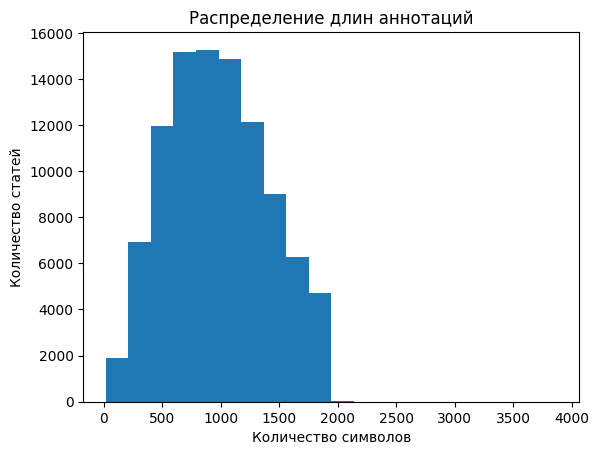

In [5]:
paper_df.normalized_abstract.map(len).plot.hist( 
    bins=20,
    title='Распределение длин аннотаций',
    xlabel='Количество символов',
    ylabel='Количество статей',
);

* Длина текстов имеет близкое к нормальному распределение.
* Подавляющее большинство текстов имеет длину до 2000 символов.
* Присутствуют единичные выбросы до 4000 символов.
* Если предположить, что длина одного токена в среднем 4 символа, то практически все тексты полностью поместятся
  в контекстное окно энкодера размером 512 токенов.

Проверим, встречаются ли в аннотациях дубликаты.

In [6]:
duplicated_paper_df = paper_df[paper_df.abstract.duplicated()]
duplicated_paper_df

,submitter,authors,title,comments,journal-ref,doi,report-no,categories,license,abstract,versions,update_date,authors_parsed,normalized_abstract
id,,,,,,,,,,,,,,
1405.4097,Ana Mestrovic,"Kristina Ban, Ivan Ivaki\'c and Ana Me\v{s}tro...",A preliminary study of Croatian Language Sylla...,in Proceedings MIPRO junior - Student Papers,IEEE 36th International Convention on Informat...,None,None,cs.CL,http://arxiv.org/licenses/nonexclusive-distrib...,This paper presents preliminary results of C...,"[{'version': 'v1', 'created': 'Fri, 16 May 201...",2014-07-18,"[[Ban, Kristina, ], [Ivakić, Ivan, ], [Meštrov...",This paper presents preliminary results of Cro...
2406.18144,Min Ren,"Min Ren, Yunlong Wang, Yuhao Zhu, Yongzhen Hua...",Artificial Immune System of Secure Face Recogn...,None,International Journal of Computer Vision (IJCV...,10.1007/s11263-024-02153-0,None,cs.CV,http://arxiv.org/licenses/nonexclusive-distrib...,Insect production for food and feed presents...,"[{'version': 'v1', 'created': 'Wed, 26 Jun 202...",2024-06-27,"[[Ren, Min, ], [Wang, Yunlong, ], [Zhu, Yuhao,...",Insect production for food and feed presents a...
cond-mat/0311225,Philip Phillips,Dimitrios Galanakis and Philip Phillips,Mottness: Asymptotic Slavery,This paper has been withdrawn,None,None,None,cond-mat.str-el,None,This paper has been withdrawn by the authors.\n,"[{'version': 'v1', 'created': 'Tue, 11 Nov 200...",2007-05-23,"[[Galanakis, Dimitrios, ], [Phillips, Philip, ]]",This paper has been withdrawn by the authors.
hep-th/0111214,Antonio F. Ranada,"Antonio F. Ranada (Universidad Complutense, Ma...",A topological formulation of the Planck-Einste...,"18 pages, no figures Reason of replacement: th...",None,None,None,hep-th quant-ph,None,The paper has been withdrawn\n,"[{'version': 'v1', 'created': 'Fri, 23 Nov 200...",2007-05-23,"[[Ranada, Antonio F., , Universidad Complutens...",The paper has been withdrawn
math/0001054,Doron Levy,Adrian Constantin and Doron Levy,Statistical Mechanics of the Periodic Camassa-...,0 pages,None,None,None,math.AP,None,The paper has been withdrawn\n,"[{'version': 'v1', 'created': 'Mon, 10 Jan 200...",2007-05-23,"[[Constantin, Adrian, ], [Levy, Doron, ]]",The paper has been withdrawn
math/0401285,Apoloniusz Tyszka,Apoloniusz Tyszka,A discrete form of the theorem that each field...,"to appear in Aequationes Math., Theorem 5 prov...","Aequationes Mathematicae 71 (2006), no. 1-2, p...",10.1007/s00010-005-2801-y,None,math.NT math.AC,None,Let K be a field and F denote the prime fiel...,"[{'version': 'v1', 'created': 'Wed, 21 Jan 200...",2007-05-23,"[[Tyszka, Apoloniusz, ]]",Let K be a field and F denote the prime field ...
math/0509686,Alik Abakarov,"A. Sh. Abakarov, Yu. A. Sushkov",Global optimization: algorithms and software,This paper has been withdrawn by the author,None,None,None,math.OC,None,This paper has been withdrawn by the author.\n,"[{'version': 'v1', 'created': 'Thu, 29 Sep 200...",2007-05-23,"[[Abakarov, A. Sh., ], [Sushkov, Yu. A., ]]",This paper has been withdrawn by the author.


Дубликаты встречаются.
На всякий случай удалим их из датасета, чтобы они не влияли на оценку качества будущей модели.

In [7]:
paper_df.drop_duplicates('abstract', keep=False, inplace=True)

Теперь загрузим датасет с тестовыми запросами.

In [8]:
test_df = pd.read_csv(DATA_DIR / 'test_sample.csv')
test_df

,id,abstract,query
0,2412.16732,A new platinate was recently discovered when...,What unique composition and decomposition beha...
1,nucl-th/9602019,The production cross sections of various fra...,How does the inclusion of statistical decay af...
2,2501.05500,This survey provides a comprehensive examina...,What are the core components of modern zero-kn...
3,2506.20892,A critical challenge for operating fusion burn...,How does impurity seeding affect the timing an...
4,2208.02031,"In this work, we present the first corpus fo...",What is the primary challenge of the newly dev...
...,...,...,...
995,2409.18116,We estimate the average of any arithmetic fu...,What are the conditions under which we can est...
996,2311.13142,We focus on a scenario of non-Hermitian bulk...,What new application does the adapted non-Herm...
997,astro-ph/0604183,We carried out a one-night optical V and nea...,What evidence suggests that the near-infrared ...
998,1707.08140,Vertically stacked van der Waals heterostruc...,What effect does processing in an inert gas en...


Удалим из датасета записи, которые соответствуют статьям с дублирующимися аннотациями.

In [9]:
test_df = test_df[~test_df.id.isin(duplicated_paper_df.index)]
len(test_df)

1000

---

## Разработка retrieval-системы

Цель — разработать retrieval-систему, которая будет достигать значения метрики $MRR@5 = 0.91$ на подготовленном выше
датасете.

* Будем реализовывать систему в виде класса с интерфейсом из двух основных методов:
  * `add_documents` — добавление документов в хранилище;
  * `__call__` — поиск $k$ наиболее релевантных документов по запросу.
* Предусмотрим возможность использования дополнительных атрибутов для расширения функционала системы:
  * `document_preprocessor` — функция для предварительной обработки добавляемых документов;
  * `reranker` — модель для переранжирования извлечённых документов.
* Для реализации векторного хранилища будем использовать `langchain.vectorstores.FAISS`.

Обернём данные каждой статьи в `Document`.

In [10]:
from langchain_core.documents import Document

documents = [
    Document(normalized_abstract, metadata=paper_data.to_dict())
    for normalized_abstract, paper_data in paper_df.reset_index().set_index('normalized_abstract').iterrows()
]
documents[0]

Document(metadata={'id': '0704.0038', 'submitter': 'Maxim A. Yurkin', 'authors': 'Maxim A. Yurkin, Alfons G. Hoekstra', 'title': 'The discrete dipole approximation: an overview and recent developments', 'comments': '36 pages, 1 figure; added several corrections according to the\n  published erratum except for Eq.(5) (it was correct in the original paper)', 'journal-ref': 'J.Quant.Spectrosc.Radiat.Transf. 106, 558-589 (2007); Erratum:\n  J.Quant.Spectrosc.Radiat.Transf. 171, 82-83 (2016)', 'doi': '10.1016/j.jqsrt.2007.01.034 10.1016/j.jqsrt.2015.11.025', 'report-no': None, 'categories': 'physics.optics physics.comp-ph', 'license': 'http://creativecommons.org/licenses/by-nc-nd/4.0/', 'abstract': '  We present a review of the discrete dipole approximation (DDA), which is a\ngeneral method to simulate light scattering by arbitrarily shaped particles. We\nput the method in historical context and discuss recent developments, taking\nthe viewpoint of a general framework based on the integral 

Реализуем класс retrieval-системы.

In [11]:
from langchain.vectorstores import FAISS
from langchain_community.docstore.in_memory import InMemoryDocstore
from operator import itemgetter
from tqdm.auto import tqdm

class FaissRetriever:
    def __init__(self, embedding_function, index, document_preprocessor=None, reranker=None, faiss_kwargs=None):
        self.vector_store = FAISS(
            embedding_function=embedding_function,
            index=index,
            docstore=InMemoryDocstore(),
            index_to_docstore_id={},
            **(faiss_kwargs or {}),
        )
        self.document_preprocessor = document_preprocessor
        self.reranker = reranker

    def add_documents(self, documents, batch_size=None):
        if batch_size is None:
            self._add_document_batch(documents)
        else:
            for i in tqdm(range(0, len(documents), batch_size), desc='Adding documents', leave=False):
                self._add_document_batch(documents[i:i+batch_size])

    def _add_document_batch(self, documents):
        if self.document_preprocessor is not None:
            documents = self.document_preprocessor(documents)
        self.vector_store.add_documents(documents)

    def __call__(self, query, k=1):
        documents = self.vector_store.similarity_search(query, k)
        if self.reranker is not None:
            # Переранжируем извлечённые документы.
            similarities = self.reranker.predict([(query, document.page_content) for document in documents])
            documents = list(map(itemgetter(0), sorted(zip(documents, similarities), key=itemgetter(1), reverse=True)))
        return documents

    def __hash__(self):
        return hash(self.vector_store) ^ hash(self.reranker) ^ hash(self.document_preprocessor)

Создадим экземпляр класса и заполним его документами из датасета.

In [12]:
import faiss
from langchain_huggingface import HuggingFaceEmbeddings

baseline_retriever = FaissRetriever(
    embedding_function=HuggingFaceEmbeddings(model_name='all-MiniLM-L6-v2'),
    index=faiss.IndexFlatL2(384),
)
baseline_retriever.add_documents(documents, batch_size=1000)

Adding documents:   0%|          | 0/99 [00:00<?, ?it/s]

Реализуем функцию, которая будет тестировать retrieval-систему, вычисляя $MRR$ и замеряя среднее время поиска на один
запрос.
Затем протестируем с помощью неё созданную систему.

In [13]:
from dataclasses import dataclass
from datetime import datetime, timedelta
from functools import lru_cache
from tqdm.auto import tqdm


@dataclass(frozen=True)
class RetrieverTestResult:
    k: int
    mrr: float
    average_search_time: timedelta

    def _repr_html_(self):
        data = [{f'MRR@{self.k}': self.mrr, 'Average search time': self.average_search_time.total_seconds() * 1e3}]
        return pd.DataFrame(data).to_html(index=False, formatters=['{:.4f}'.format, '{:.2f} ms'.format])

@lru_cache(1000)
def test_retriever(retriever, *, k=5, desc='Testing retriever'):
    reciprocal_rank_sum = 0
    total_search_time = timedelta()
    for test_case in tqdm(test_df.itertuples(), total=len(test_df), desc=desc, leave=False):
        start_time = datetime.now()
        documents = retriever(test_case.query, k)
        total_search_time += datetime.now() - start_time
        assert len(documents) <= k
        for rank, document in enumerate(documents, start=1):
            if document.metadata['id'] == test_case.id:
                reciprocal_rank = 1 / rank
                break
        else:
            reciprocal_rank = 0
        reciprocal_rank_sum += reciprocal_rank
    return RetrieverTestResult(
        k=k,
        mrr=reciprocal_rank_sum / len(test_df),
        average_search_time=total_search_time / len(test_df),
    )

test_retriever(baseline_retriever)

Testing retriever:   0%|          | 0/1000 [00:00<?, ?it/s]

MRR@5,Average search time
0.8660,13.35 ms


$MRR@5$ пока не достиг необходимого уровня 0.91.

Добавим reranker и протестируем систему ещё раз.

In [14]:
from sentence_transformers import CrossEncoder

baseline_retriever.reranker = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2')
test_retriever(baseline_retriever)

Testing retriever:   0%|          | 0/1000 [00:00<?, ?it/s]

MRR@5,Average search time
0.9108,25.69 ms


Целевое значение $MRR@5$ достигнуто!

---

## Профилирование retrieval-системы

Цель — замерить время работы различных участков retrieval-системы, чтобы обнаружить её узкие места.

* Для профилирования воспользуемся модулем `cProfile`.

Прогоним систему на тестовом датасете и выведем топ операций по суммарному машинному времени.

*Функцию `test_retriever` будем вызывать через `__wrapped__`, чтобы обойти кеширование.*

In [15]:
import cProfile
import pstats

with cProfile.Profile() as profiler:
    test_retriever.__wrapped__(baseline_retriever)

pstats.Stats(profiler).sort_stats('tottime').print_stats(20); 

Testing retriever:   0%|          | 0/1000 [00:00<?, ?it/s]

         23656159 function calls (22215555 primitive calls) in 30.872 seconds

   Ordered by: internal time
   List reduced from 725 to 20 due to restriction <20>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
     6000    7.213    0.001    7.213    0.001 {method 'cpu' of 'torch._C.TensorBase' objects}
     1000    7.079    0.007    7.079    0.007 {built-in method faiss._swigfaiss_avx2.IndexFlat_search}
    75000    2.120    0.000    2.120    0.000 {built-in method torch._C._nn.linear}
     2000    1.352    0.001    1.352    0.001 {method 'encode_batch' of 'tokenizers.Tokenizer' objects}
24000/6000    1.155    0.000    2.044    0.000 c:\Users\nygov\AppData\Local\Programs\Python\Python313\Lib\site-packages\transformers\tokenization_utils_base.py:90(flatten)
6998900/6499601    0.771    0.000    1.087    0.000 {built-in method builtins.isinstance}
124000/1000    0.529    0.000    1.783    0.002 c:\Users\nygov\AppData\Local\Programs\Python\Python313\Lib\site-packa

Рассмотрим наиболее долгие операции и предложим способы их ускорения:

* Больше всего машинного времени занимает метод `torch._C.TensorBase.cpu`, то есть перенос тензоров с GPU на CPU.
  Непосредственно в коде ноутбука перенос тензоров на CPU не производится, значит, это происходит внутри какой-то из
  библиотек.
  Возможный путь ускорения — исследовать, в каких именно местах кода происходит перенос тензоров.
  Может быть, какие-то промежуточные операции можно выполнять на GPU, чтобы не переносить тензоры лишний раз.
* Далее с небольшим отрывом идёт метод `faiss._swigfaiss_avx2.IndexFlat_search`, что вполне ожидаемо, поскольку текущий
  индекс перебирает все значения подряд.
  Способ ускорения — замена `IndexFlatL2` на оптимизированный индекс, например, `IndexHNSWFlat`.
* Метод `torch._C._nn.linear` вызывается во время инференса нейросетей (генерация эмбеддинга запроса, переранжирование).
  Его можно ускорить, перейдя на модели с меньшим количеством параметров.
* Метод `tokenizers.Tokenizer` отвечает за токенизацию текстов.
  Непосредственно в коде ноутбука токенизаторы не вызываются, поэтому возможный путь ускорения — исследовать, что
  происходит под капотом классов `HuggingFaceEmbeddings` и `CrossEncoder`, которые производят токенизацию.
  Возможно, там есть какие-то параметры, позволяющие ускорить её.
* Метод `tokenization_utils_base.flatten`, по всей видимости, является неотъемлемой частью механизма токенизации в
  используемых библиотеках, поэтому время его работы вряд ли можно уменьшить.

Идущие далее по списку операции занимают на порядок меньше машинного времени, чем перечисленные выше, поэтому не будем
их рассматривать.

*Вычисления производились на RTX 3060, поэтому результаты для CPU или других видеокарт могут отличаться.*

---

## Улучшение точности retrieval-системы

Теперь, когда получена baseline-система, достигающая необходимого уровня точности, опробуем несколько способов сделать
её ещё точнее.

### Разбиение текста

Как было замечено в разделе EDA, большинство текстов должны полностью поместиться в контекстное окно в том случае, если
средняя длина токена — 4 символа, а размер окна — 512 токенов.
Однако использованная модель `all-MiniLM-L6-v2`, согласно
[документации](https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2#intended-uses), отсекает всё, что выходит
за границы 256 токенов, а средняя длина токена на практике может оказаться меньше.
Поэтому можно предположить, что часть текста, содержащая важную для поиска информацию, в некоторых случаях обрезается на
входе в энкодер, и это снижает среднюю точность поиска.
Очевидный способ решения такой проблемы — разбить тексты на более мелкие части, которые заведомо будут помещаться в
контекстное окно.

Создадим сплиттер, рекурсивно разбивающий тексты по предложениям до тех пор, пока они все не будут помещаться в
контекстное окно модели, и используем его для предварительной обработки документов, добавляемых в хранилище.

In [16]:
from transformers import AutoTokenizer
from langchain_text_splitters.character import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter.from_huggingface_tokenizer(
    AutoTokenizer.from_pretrained('sentence-transformers/all-MiniLM-L6-v2'),
    chunk_size=256,
    chunk_overlap=128,
    separators=['. ', '! ', '? '],
    keep_separator=False,
)
retriever_with_splitter = FaissRetriever(
    embedding_function=HuggingFaceEmbeddings(model_name='all-MiniLM-L6-v2'),
    index=faiss.IndexFlatL2(384),
    reranker=CrossEncoder('cross-encoder/ms-marco-MiniLM-L6-v2'),
    document_preprocessor=text_splitter.split_documents,
)
retriever_with_splitter.add_documents(documents, batch_size=1000)
test_retriever(retriever_with_splitter)

Adding documents:   0%|          | 0/99 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (596 > 512). Running this sequence through the model will result in indexing errors


Testing retriever:   0%|          | 0/1000 [00:00<?, ?it/s]

MRR@5,Average search time
0.9149,26.57 ms


$MRR@5$ немного вырос, а скорость поиска практически не изменилось.

### Использование энкодера с большим количеством параметров

Согласно таблице, приведённой в
[документации](https://www.sbert.net/docs/sentence_transformer/pretrained_models.html#original-models), наилучшие
результаты на задаче генерации эмбеддингов демонстрирует модель `all-mpnet-base-v2` — у неё примерно в 5 раз больше
параметров, чем у исходной `all-MiniLM-L6-v2`.
Попробуем использовать её.

In [17]:
retriever_with_big_encoder = FaissRetriever(
    embedding_function=HuggingFaceEmbeddings(model_name='all-mpnet-base-v2'),
    index=faiss.IndexFlatL2(768),
    reranker=CrossEncoder('cross-encoder/ms-marco-MiniLM-L6-v2'),
)
retriever_with_big_encoder.add_documents(documents, batch_size=1000)
test_retriever(retriever_with_big_encoder)

Adding documents:   0%|          | 0/99 [00:00<?, ?it/s]

Testing retriever:   0%|          | 0/1000 [00:00<?, ?it/s]

MRR@5,Average search time
0.9175,37.19 ms


$MRR@5$ вырос, но скорость поиска ощутимо упала.
Также отметим, что добавление документов заняло почти в 10 раз больше времени.

### Использование reranker на основе LLM

Попробуем ещё один способ улучшения точности — использование reranker на основе LLM.
Использованный ранее `ms-marco-MiniLM-L6-v2` является моделью с BERT-архитектурой.
Теперь же будем использовать `Qwen3-Reranker-0.6B`, подавая в промпт запрос и текст документа с просьбой оценить их
соответствие.

Реализуем класс reranker на основе LLM.

*Код адаптирован из [документации](https://huggingface.co/Qwen/Qwen3-Reranker-0.6B#transformers-usage) `Qwen3-Reranker`.*

In [18]:
import torch
from transformers import AutoModelForCausalLM

class LLMReranker:
    def __init__(self, tokenizer, model, max_length=512, instruction=None):
        if instruction is None:
            self.instruction = 'Given a web search query, retrieve relevant passages that answer the query'
        else:
            self.instruction = instruction
        self.tokenizer = tokenizer
        self.model = model
        self.token_false_id = tokenizer.convert_tokens_to_ids('no')
        self.token_true_id = tokenizer.convert_tokens_to_ids('yes')
        self.max_length = max_length
        prefix = '<|im_start|>system\nJudge whether the Document meets the requirements based on the Query and the Instruct provided. Note that the answer can only be "yes" or "no".<|im_end|>\n<|im_start|>user\n'
        suffix = '<|im_end|>\n<|im_start|>assistant\n<think>\n\n</think>\n\n'
        self.prefix_tokens = tokenizer.encode(prefix, add_special_tokens=False)
        self.suffix_tokens = tokenizer.encode(suffix, add_special_tokens=False)

    def format_instruction(self, query, doc):
        return f'<Instruct>: {self.instruction}\n<Query>: {query}\n<Document>: {doc}'

    def process_inputs(self, pairs):
        inputs = self.tokenizer(
            pairs, padding=False, truncation='longest_first',
            return_attention_mask=False, max_length=self.max_length - len(self.prefix_tokens) - len(self.suffix_tokens)
        )
        for i, ele in enumerate(inputs['input_ids']):
            inputs['input_ids'][i] = self.prefix_tokens + ele + self.suffix_tokens
        inputs = self.tokenizer.pad(inputs, padding=True, return_tensors='pt', max_length=self.max_length)
        for key in inputs:
            inputs[key] = inputs[key].to(self.model.device)
        return inputs

    @torch.no_grad()
    def compute_logits(self, inputs):
        batch_scores = self.model(**inputs).logits[:, -1, :]
        true_vector = batch_scores[:, self.token_true_id]
        false_vector = batch_scores[:, self.token_false_id]
        batch_scores = torch.stack([false_vector, true_vector], dim=1)
        batch_scores = torch.nn.functional.log_softmax(batch_scores, dim=1)
        return batch_scores[:, 1].exp().tolist()
    
    def predict(self, pairs):
        inputs = self.process_inputs([self.format_instruction(query, doc) for query, doc in pairs])
        return self.compute_logits(inputs)


llm_reranker = LLMReranker(
    tokenizer=AutoTokenizer.from_pretrained('Qwen/Qwen3-Reranker-0.6B', padding_side='left'),
    model=AutoModelForCausalLM.from_pretrained('Qwen/Qwen3-Reranker-0.6B').to('cuda').eval(),
)

llm_reranker.predict(
    [
        ('What is the capital of China?', 'The capital of China is Beijing.'),
        ('What is the capital of France?', 'The capital of China is Beijing.'),
    ]
)

You're using a Qwen2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
c:\Users\nygov\AppData\Local\Programs\Python\Python313\Lib\site-packages\transformers\tokenization_utils_base.py:2779: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


[0.9994982481002808, 7.033636939013377e-05]

Инициализируем retrieval-систему c LLM-reranker и оценим её точность.

In [19]:
retriever_with_llm_reranker = FaissRetriever(
    embedding_function=HuggingFaceEmbeddings(model_name='all-MiniLM-L6-v2'),
    index=faiss.IndexFlatL2(384),
    reranker=llm_reranker,
)
retriever_with_llm_reranker.add_documents(documents, batch_size=1000)
test_retriever(retriever_with_llm_reranker)

Adding documents:   0%|          | 0/99 [00:00<?, ?it/s]

Testing retriever:   0%|          | 0/1000 [00:00<?, ?it/s]

MRR@5,Average search time
0.9262,467.75 ms


$MRR@5$ заметно вырос, однако скорость поиска упала на порядок.

### Комбинирование модификаций

Наконец, возьмём все испробованные модификации и объединим их в одну retrieval-систему, чтобы проверить, превзойдёт ли
она каждую отдельную модификацию.

In [20]:
ultimate_retriever = FaissRetriever(
    embedding_function=HuggingFaceEmbeddings(model_name='all-mpnet-base-v2'),
    index=faiss.IndexFlatL2(768),
    reranker=llm_reranker,
    document_preprocessor=text_splitter.split_documents,
)
ultimate_retriever.add_documents(documents, batch_size=1000)
test_retriever(ultimate_retriever)

Adding documents:   0%|          | 0/99 [00:00<?, ?it/s]

Testing retriever:   0%|          | 0/1000 [00:00<?, ?it/s]

MRR@5,Average search time
0.9275,403.84 ms


Система действительно превзошла все предыдущие модификации по $MRR@5$, хоть разница и оказалась очень незначительной.

### Сравнение retrieval-систем

Чтобы сравнить полученные retrieval-системы, построим таблицу, в которой для каждой из них отобразим значение $MRR@5$,
среднее время поиска на один запрос, а также отличия этих двух характеристик от baseline-системы.

In [21]:
from dataclasses import asdict

def create_retriever_leaderboard(retrievers):
    leaderboard_data = {}
    for retriever_name, retriever in tqdm(retrievers.items(), desc='Creating leaderboard', leave=False):
        leaderboard_data[retriever_name] = asdict(test_retriever(retriever))
    baseline_test_result = test_retriever(baseline_retriever)
    leaderboard_df = pd.DataFrame(leaderboard_data).T.sort_values(['mrr', 'average_search_time'], ascending=[False, True])
    leaderboard_df['mrr_delta'] = leaderboard_df.mrr - baseline_test_result.mrr
    leaderboard_df['average_search_time_delta'] = leaderboard_df.average_search_time / baseline_test_result.average_search_time - 1
    return leaderboard_df.style.format({
        'mrr': '{:.4f}',
        'average_search_time': lambda t: f'{t.total_seconds() * 1000:.2f} ms',
        'mrr_delta': '{:.4f}',
        'average_search_time_delta': '{:.0%}'
    })

create_retriever_leaderboard(
    retrievers={
        retriever_name: globals()[retriever_name] for retriever_name in [
            'baseline_retriever',
            'retriever_with_splitter',
            'retriever_with_big_encoder',
            'retriever_with_llm_reranker',
            'ultimate_retriever',
        ]
    },
)

Creating leaderboard:   0%|          | 0/5 [00:00<?, ?it/s]

,k,mrr,average_search_time,mrr_delta,average_search_time_delta
ultimate_retriever,5,0.9275,403.84 ms,0.0167,1472%
retriever_with_llm_reranker,5,0.9262,467.75 ms,0.0153,1721%
retriever_with_big_encoder,5,0.9175,37.19 ms,0.0067,45%
retriever_with_splitter,5,0.9149,26.57 ms,0.0041,3%
baseline_retriever,5,0.9108,25.69 ms,0.0000,0%


Подведём итог:

* Все испробованные модификации retrieval-системы продемонстрировали прирост точности поиска и уменьшение его скорости
  по сравнению с baseline-экземпляром.
* `ultimate_retriever`, сочетающий в себе различные методы улучшения baseline-системы, продемонстрировал самое высокое
  значение $MRR@5$ — 0.9275.
* Модели, использующие LLM в качестве reranker (`retriever_with_llm_reranker`, `ultimate_retriever`), выполняют поиск
  примерно в 15 раз медленнее конкурентов, но зато обеспечивают наивысшую точность.
* Среди моделей, не использующих LLM, наибольшую точность ($MRR@5 = 0.9175$) продемонстрировал
  `retriever_with_big_encoder`, однако ценой стало увеличение времени поиска почти в полтора раза.
* `retriever_with_splitter`, разбивающий тексты на более мелкие фрагменты, показал увеличение $MRR@5$ на 0.0041 по
  сравнению с baseline-системой практически без падения скорости поиска.

---

## Оптимизация времени поиска

По аналогии с предыдущим разделом, возьмём baseline-систему и попробуем применить к ней различные модификации, только на
этот раз вместо точности будем пытаться увеличить скорость поиска.

### Использование reranker меньшего размера

Согласно [документации](https://www.sbert.net/docs/sentence_transformer/pretrained_models.html#original-models),
модель `all-MiniLM-L6-v2`, используемая для генерации эмбеддингов, является одной из самых маленьких и
быстрых, так что не будем пытаться подобрать ей замену.
Вместо этого попробуем использовать reranker меньшего размера, например `ms-marco-MiniLM-L2-v2`.

In [22]:
retriever_with_small_reranker = FaissRetriever(
    embedding_function=HuggingFaceEmbeddings(model_name='all-MiniLM-L6-v2'),
    index=faiss.IndexFlatL2(384),
    reranker=CrossEncoder('cross-encoder/ms-marco-MiniLM-L2-v2'),
)
retriever_with_small_reranker.add_documents(documents, batch_size=1000)
test_retriever(retriever_with_small_reranker)

Adding documents:   0%|          | 0/99 [00:00<?, ?it/s]

Testing retriever:   0%|          | 0/1000 [00:00<?, ?it/s]

MRR@5,Average search time
0.9014,21.48 ms


Скорость поиска возросла, а $MRR@5$ немного упал.

### Использование индекса на основе графа

Теперь попробуем ускорить поиск за счёт использования оптимизированного индекса FAISS: заменим `IndexFlatL2` на
`IndexHNSWFlat`.

In [23]:
retriever_with_hnsw_16_index = FaissRetriever(
    embedding_function=HuggingFaceEmbeddings(model_name='all-MiniLM-L6-v2'),
    index=faiss.IndexHNSWFlat(384, 16),
    reranker=CrossEncoder('cross-encoder/ms-marco-MiniLM-L6-v2'),
)
retriever_with_hnsw_16_index.add_documents(documents, batch_size=1000)
test_retriever(retriever_with_hnsw_16_index)

Adding documents:   0%|          | 0/99 [00:00<?, ?it/s]

Testing retriever:   0%|          | 0/1000 [00:00<?, ?it/s]

MRR@5,Average search time
0.8065,18.37 ms


Скорость поиска заметно возросла, но $MRR@5$ сильно упал.

Попробуем увеличить количество соседей в графе с 16 до 256.

In [24]:
retriever_with_hnsw_256_index = FaissRetriever(
    embedding_function=HuggingFaceEmbeddings(model_name='all-MiniLM-L6-v2'),
    index=faiss.IndexHNSWFlat(384, 256),
    reranker=CrossEncoder('cross-encoder/ms-marco-MiniLM-L6-v2'),
)
retriever_with_hnsw_256_index.add_documents(documents, batch_size=1000)
test_retriever(retriever_with_hnsw_256_index)

Adding documents:   0%|          | 0/99 [00:00<?, ?it/s]

Testing retriever:   0%|          | 0/1000 [00:00<?, ?it/s]

MRR@5,Average search time
0.8763,18.66 ms


Время поиска почти не изменилось, а падение $MRR@5$ стало уже не таким значительным.

### Использование инвертированного индекса

Попробуем другой оптимизированный индекс FAISS — `IndexIVFFlat`.

Для начала извлечём из документов эмбеддинги, поскольку они потребуются для обучения индекса.

In [25]:
import numpy as np

embeddings = HuggingFaceEmbeddings(model_name='all-MiniLM-L6-v2')
embedding_vectors = np.array(embeddings.embed_documents(paper_df.normalized_abstract))

Создадим и обучим индекс.

In [26]:
ivf_100_index = faiss.IndexIVFFlat(faiss.IndexFlatL2(384), 384, 100, faiss.METRIC_L2)
ivf_100_index.train(embedding_vectors)

Инициализируем retrieval-систему и протестируем её.

In [27]:
retriever_with_ivf_100_index = FaissRetriever(
    embedding_function=embeddings,
    index=ivf_100_index,
    reranker=CrossEncoder('cross-encoder/ms-marco-MiniLM-L6-v2'),
)
retriever_with_ivf_100_index.add_documents(documents, batch_size=1000)
test_retriever(retriever_with_ivf_100_index)

Adding documents:   0%|          | 0/99 [00:00<?, ?it/s]

Testing retriever:   0%|          | 0/1000 [00:00<?, ?it/s]

MRR@5,Average search time
0.5441,18.35 ms


$MRR@5$ упал катастрофически.

Попробуем уменьшить количество кластеров с 100 до 10.

In [28]:
ivf_10_index = faiss.IndexIVFFlat(faiss.IndexFlatL2(384), 384, 10, faiss.METRIC_L2)
ivf_10_index.train(embedding_vectors)

retriever_with_ivf_10_index = FaissRetriever(
    embedding_function=HuggingFaceEmbeddings(model_name='all-MiniLM-L6-v2'),
    index=ivf_10_index,
    reranker=CrossEncoder('cross-encoder/ms-marco-MiniLM-L6-v2'),
)
retriever_with_ivf_10_index.add_documents(documents, batch_size=1000)
test_retriever(retriever_with_ivf_10_index)

Adding documents:   0%|          | 0/99 [00:00<?, ?it/s]

Testing retriever:   0%|          | 0/1000 [00:00<?, ?it/s]

MRR@5,Average search time
0.6936,19.13 ms


$MRR@5$ немного вырос по сравнению с прошлым разом, но всё равно остаётся очень низким.

### Комбинирование модификаций

Из всех опробованных в этом разделе модификаций только две смогли ускорить поиск, сохранив точность в разумных пределах:
уменьшенный reranker и графовый индекс с 256 соседями.
Совместим их в одной retrieval-системе и протестируем её.
Поскольку эти модификации ускоряют независимые участки системы, эффект от их применения должен получиться аддитивным.

In [29]:
fast_retriever = FaissRetriever(
    embedding_function=HuggingFaceEmbeddings(model_name='all-MiniLM-L6-v2'),
    index=faiss.IndexHNSWFlat(384, 256),
    reranker=CrossEncoder('cross-encoder/ms-marco-MiniLM-L2-v2'),
)
fast_retriever.add_documents(documents, batch_size=1000)
test_retriever(fast_retriever)

Adding documents:   0%|          | 0/99 [00:00<?, ?it/s]

Testing retriever:   0%|          | 0/1000 [00:00<?, ?it/s]

MRR@5,Average search time
0.8654,11.43 ms


Скорость поиска беспрецедентно выросла; $MRR@5$ упал, но остался в разумных пределах.

### Сравнение retrieval-систем

In [30]:
create_retriever_leaderboard(
    retrievers={
        retriever_name: globals()[retriever_name] for retriever_name in [
            'baseline_retriever',
            'retriever_with_small_reranker',
            'retriever_with_hnsw_16_index',
            'retriever_with_hnsw_256_index',
            'retriever_with_ivf_100_index',
            'retriever_with_ivf_10_index',
            'fast_retriever',
        ]
    },
)

Creating leaderboard:   0%|          | 0/7 [00:00<?, ?it/s]

,k,mrr,average_search_time,mrr_delta,average_search_time_delta
baseline_retriever,5,0.9108,25.69 ms,0.0000,0%
retriever_with_small_reranker,5,0.9014,21.48 ms,-0.0094,-16%
retriever_with_hnsw_256_index,5,0.8763,18.66 ms,-0.0345,-27%
fast_retriever,5,0.8654,11.43 ms,-0.0454,-56%
retriever_with_hnsw_16_index,5,0.8065,18.37 ms,-0.1043,-28%
retriever_with_ivf_10_index,5,0.6936,19.13 ms,-0.2173,-26%
retriever_with_ivf_100_index,5,0.5441,18.35 ms,-0.3667,-29%


Подведём итог:

* Все испробованные модификации retrieval-системы продемонстрировали прирост скорости и снижение точности поиска по
  сравнению с baseline-экземпляром.
* `retriever_with_small_reranker` продемонстрировал уменьшение времени поиска на 16% при падении $MRR@5$ на 0.0094 —
  такая оптимизация представляется наиболее полезной в тех случаях, когда важно сохранить точность поиска.
* `retriever_with_hnsw_256_index` продемонстрировал уменьшение времени поиска на 27% при падении $MRR@5$ на 0.0345.
* `fast_retriever`, комбинирующий две предыдущие модификации, продемонстрировал уменьшение времени поиска на 56% при
  падении $MRR@5$ на 0.0454 — такая оптимизация представляется наиболее полезной в тех ситуациях, где критически важна
  быстрая работа поиска.
* Все остальные оптимизации не смогли уменьшить время поиска больше, чем на 30%, и показали значительно более низкую
  точность — использование их на практике представляется нерациональным.

---

## Вывод

* Была реализована retrieval-система, выполняющая поиск по статьям из arXiv и достигающая на этой задаче поставленного
  уровня точности $MRR@5 ≥ 0.91$.
* retrieval-система была отпрофилирована, были выявлены её узкие места и предложены способы их ускорения.
* Были исследованы различные методы повышения точности поиска системы.
  Наибольшую точность ($MRR@5 = 0.9275$) показала модификация, комбинирующая различные методы: измельчение текстов,
  энкодер с большим количеством параметров и reranker на основе LLM.
* Были исследованы различные методы ускорения поиска системы.
  Модификации, использующие reranker с меньшим количеством параметров и оптимизированный индекс, показали значительное
  сокращение времени поиска (от 16% до 56%) при небольшом снижении $MRR@5$ (от 0.0094 до 0.0454).